安隆公司詐欺案資料集https://www.kaggle.com/c/ml100marathon/overview

[嫌疑犯標籤]

poi : 是否是嫌疑人 (True=POI, Flase=Non-POI)

[郵件相關]

1.email_address                                                                                       
2.to_messages : 發送郵件的數量                                                                         
3.from_messages : 收到郵件的數量                                                                       
4.from_poi_to_this_person: 收到來自POI 的郵件數量                                                       
5.from_this_person_to_poi: 發送給POI的郵件數量                                                         
6.shared_receipt_with_poi: 收到來自POI抄送郵件的數量

[財物相關]

1.salary : 工資                                                                                       
2.bonus : 獎金                                                                                       
3.long_term_incentive : 長期激勵報酬                                                                   
4.deferred_income : 延期收入                                                                           
5.deferral_payments : 延期薪資                                                                         
6.loan_advances : 預支貸款                                                                             
7.other                                                                                               
8.expenses : 開支                                                                                     
9.director_fees : 董事費                                                                               
10.total_payments : 總薪資與獎金                                                                       
11.exercised_stock_options : 已使用的股票期權                                                         
12.restricted_stock : 受限股票                                                                         
13.restricted_stock_deferred: 延期的受限股票                                                           
14.total_stock_value : 總股票價值                                                                     

有關資料集中財務資料欄位的特徵: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (單位皆為美元)。

有關 email 的特徵: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (除了 email_address，其餘皆為次數)

因此，財務資料得資料應該都是連續型的數字資料，email 通訊的資料欄位應該都是離散型的數字資料。

In [23]:
#載入分析套件及資料集
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,learning_curve,cross_val_score
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn import metrics

#解決分類樣本數量不平衡的狀況的套件
from imblearn.over_sampling import SMOTE

In [24]:
#讀取資料集
df = pd.read_csv('train_data.csv')
train_Y = df['poi']

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 22 columns):
name                         113 non-null object
bonus                        61 non-null float64
deferral_payments            28 non-null float64
deferred_income              34 non-null float64
director_fees                13 non-null float64
email_address                83 non-null object
exercised_stock_options      81 non-null float64
expenses                     73 non-null float64
from_messages                65 non-null float64
from_poi_to_this_person      65 non-null float64
from_this_person_to_poi      65 non-null float64
loan_advances                2 non-null float64
long_term_incentive          49 non-null float64
other                        69 non-null float64
poi                          113 non-null bool
restricted_stock             82 non-null float64
restricted_stock_deferred    10 non-null float64
salary                       73 non-null float64
shared_receipt_wi

### 資料集中共有22個欄位，其他欄位都或多或少有缺值

In [25]:
#email address 欄位沒有特別意義先拿掉， loan_advances 欄位缺失值太多，不具代表意義，所以也移除，poi 是分類標籤所以也拿掉
df= df.drop(['poi','email_address','loan_advances'],axis=1)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 19 columns):
name                         113 non-null object
bonus                        61 non-null float64
deferral_payments            28 non-null float64
deferred_income              34 non-null float64
director_fees                13 non-null float64
exercised_stock_options      81 non-null float64
expenses                     73 non-null float64
from_messages                65 non-null float64
from_poi_to_this_person      65 non-null float64
from_this_person_to_poi      65 non-null float64
long_term_incentive          49 non-null float64
other                        69 non-null float64
restricted_stock             82 non-null float64
restricted_stock_deferred    10 non-null float64
salary                       73 non-null float64
shared_receipt_with_poi      65 non-null float64
to_messages                  65 non-null float64
total_payments               96 non-null float64
total_stock_v

In [27]:
#建立資料清理函數

def DataClean(df_temp):
    num_col = ['salary', 'deferral_payments', 'total_payments', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']
    count_col = ['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] 
    
    df_clean=df_temp.copy()
    #數字型欄位， 遺失值用欄位眾數來補 
    for col in num_col:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode())
        df_clean[col] = df_clean[col].abs()  

    #記數值欄都是郵件往來次數，所以遺失值補 0 比較合理
    for col in count_col:
        df_clean[col] = df_clean[col].fillna(0)
        df_clean[col] = df_clean[col].abs()  
    
    df_clean['name'] = LabelEncoder().fit_transform(df_clean['name'])
       
    return df_clean

#建立特徵工程函數
def Feature_eng(df_temp):    
    df_FE = df_temp.copy()
    
    ''' 
    新增特徵值
    total_asset = 總薪資及獎金 + 總股票價值
    total_communication = 收到來自POI 的郵件數量 + 發送給POI的郵件數量
    '''

    df_FE['total_asset'] = df_FE['total_payments'] + df_FE['total_stock_value']
    df_FE['total_communication'] = df_FE['from_poi_to_this_person'] + df_FE['from_this_person_to_poi']
    
    df_FE = df_FE.fillna(0)
   
    return df_FE

In [28]:
#對訓練資料集做資料清理及特徵工程
df_train = DataClean(df)
df_train = Feature_eng(df_train)
df_train.describe()

,name,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,total_asset,total_communication
count,113.00000,1.130000e+02,1.130000e+02,1.130000e+02,113.000000,1.130000e+02,113.000000,113.000000,113.000000,113.000000,...,1.130000e+02,1.130000e+02,113.000000,1.130000e+02,113.000000,113.000000,1.130000e+02,1.130000e+02,1.130000e+02,113.000000
mean,56.00000,6.194126e+05,3.033747e+05,1.391793e+05,20569.415929,2.139748e+06,32973.097345,409.168142,37.274336,23.061947,...,3.286061e+05,9.396291e+05,40832.619469,2.376472e+05,639.283186,1240.212389,2.416590e+06,3.059712e+06,5.379631e+06,60.336283
std,32.76431,1.242456e+06,6.766507e+05,4.883707e+05,42321.857381,5.251192e+06,45358.746287,1607.452015,76.533402,70.089392,...,1.076375e+06,2.202460e+06,117796.853724,1.965296e+05,1039.799616,2379.796707,9.784445e+06,6.791577e+06,1.519515e+07,132.743214
min,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,28.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,1.760000e+02,0.000000e+00,0.000000,1.584030e+05,0.000000,0.000000,2.497870e+05,2.211410e+05,1.015896e+06,0.000000
50%,56.00000,2.500000e+05,0.000000e+00,0.000000e+00,0.000000,4.934890e+05,16514.000000,16.000000,0.000000,0.000000,...,2.856000e+03,3.605280e+05,0.000000,2.473380e+05,71.000000,232.000000,1.099100e+06,8.802900e+05,2.217774e+06,4.000000
75%,84.00000,7.500000e+05,1.819930e+05,2.500000e+04,0.000000,1.624396e+06,50080.000000,59.000000,37.000000,11.000000,...,2.774640e+05,6.982420e+05,0.000000,2.885420e+05,742.000000,1433.000000,1.934359e+06,2.072035e+06,4.618918e+06,50.000000
max,112.00000,8.000000e+06,2.964506e+06,3.504386e+06,125034.000000,3.434838e+07,228763.000000,14368.000000,528.000000,411.000000,...,1.035973e+07,1.476169e+07,560222.000000,1.111258e+06,4527.000000,15149.000000,1.035598e+08,4.911008e+07,1.526699e+08,939.000000


In [29]:
df_train.head()

,name,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,total_asset,total_communication
0,84,1750000.0,102500.0,3504386.0,3285.0,19794175.0,46950.0,18.0,42.0,4.0,...,174839.0,2748364.0,560222.0,420636.0,864.0,905.0,505050.0,22542539.0,23047589.0,46.0
1,92,5600000.0,7961.0,0.0,17500.0,19250000.0,29336.0,108.0,88.0,30.0,...,22122.0,6843672.0,472568.0,1111258.0,2042.0,3627.0,8682716.0,26093672.0,34776388.0,118.0
2,91,200000.0,10259.0,4167.0,36666.0,1624396.0,22884.0,39.0,13.0,14.0,...,1573324.0,869220.0,409554.0,211844.0,91.0,225.0,2003885.0,2493616.0,4497501.0,27.0
3,58,800000.0,16586.0,0.0,101250.0,0.0,118134.0,0.0,0.0,0.0,...,907502.0,985032.0,329825.0,224305.0,0.0,0.0,2652612.0,985032.0,3637644.0,0.0
4,15,1250000.0,27610.0,262500.0,102492.0,0.0,35818.0,144.0,199.0,25.0,...,486.0,126027.0,153686.0,240189.0,2188.0,2598.0,1639297.0,126027.0,1765324.0,224.0


In [30]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 21 columns):
name                         113 non-null int64
bonus                        113 non-null float64
deferral_payments            113 non-null float64
deferred_income              113 non-null float64
director_fees                113 non-null float64
exercised_stock_options      113 non-null float64
expenses                     113 non-null float64
from_messages                113 non-null float64
from_poi_to_this_person      113 non-null float64
from_this_person_to_poi      113 non-null float64
long_term_incentive          113 non-null float64
other                        113 non-null float64
restricted_stock             113 non-null float64
restricted_stock_deferred    113 non-null float64
salary                       113 non-null float64
shared_receipt_with_poi      113 non-null float64
to_messages                  113 non-null float64
total_payments               113 non-null float

### 資料前處理後，訓練資料集總共有21個特徵欄位(原本22-刪除3+新增2)

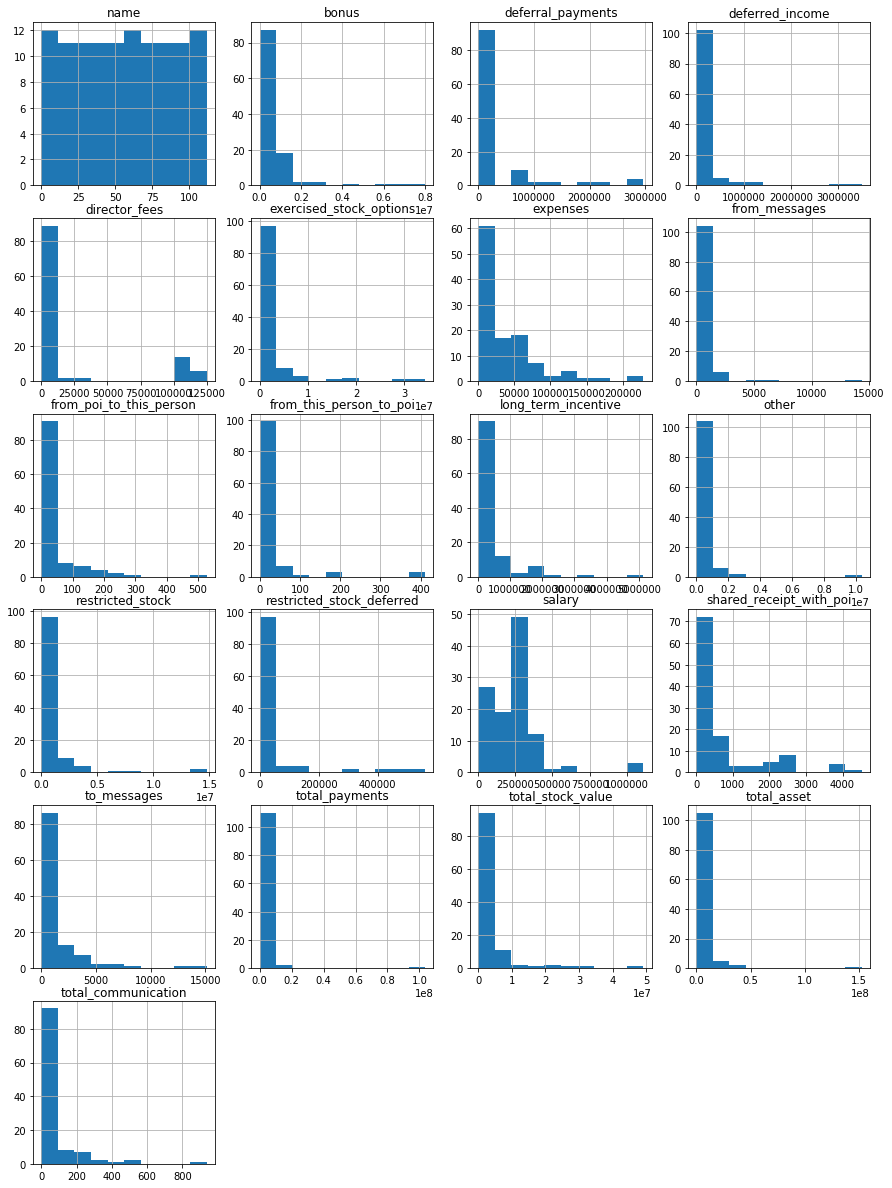

In [31]:
#將訓練資料集的每個特徵值畫出值發圖看資料分布
fig_cols = 4
fig_rows = len(df_train.columns)

plt.figure(figsize=(15,75))
for i,col in enumerate (df_train.columns):
    plt.subplot(fig_rows,fig_cols,i+1)
    df_train[col].hist()
    plt.title(str(col))
plt.show()

### 經過資料清理及特徵工程之後，從直方圖中顯示各項特徵都呈現很嚴重的偏態。因為大部分的員工都應該是守法的人，所以詐欺案的嫌疑人反而應該算是一種的異常值，因此正常的模型是要排除資料異常值，但是在這裡反而應該是要凸顯異常值以利分類模型去做判斷。所以資料清理的過程中針對異常值不做排除的動作，也特別選用要凸顯異常值的方式來填補缺失值

The POI are 13 , The Non-POI are 100


<BarContainer object of 2 artists>

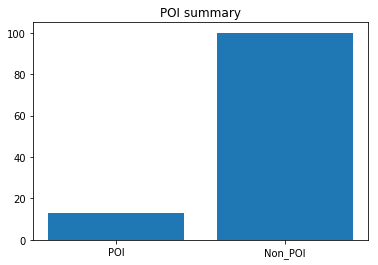

In [32]:
#顯示訓練資料集中 POI 的數量 
POI_num = [len(train_Y[train_Y==True]),len(train_Y[train_Y==False])]
print(f'The POI are {POI_num[0]} , The Non-POI are {POI_num[1]}')
plt.title('POI summary')
plt.bar(['POI', 'Non_POI'],POI_num)

###  原始訓練資料集中的嫌疑人有 13人，非嫌疑人有 100人。

### 分類標籤的比例呈現不平衡的狀態，為使分割後的訓練資料集及測試資料集在POI的比例上能達到1:1的狀態，以利訓練模型時不會特別偏重在非嫌疑人的類別，因此需要透過人工合成樣本的方式來增加嫌疑人類別的特徵資料

In [33]:
#將訓練資料集透過 SMOTE 技術，將不平衡的 POI Label 調整為 True :Fales = 1:1  
sm = SMOTE(random_state=4)
train_data_res,train_Y_res = sm.fit_sample(df_train, train_Y.ravel())
train_data_res = pd.DataFrame(train_data_res,columns=df_train.columns)

In [34]:
train_Y_res

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

The POI are 100 , The Non-POI are 100


<BarContainer object of 2 artists>

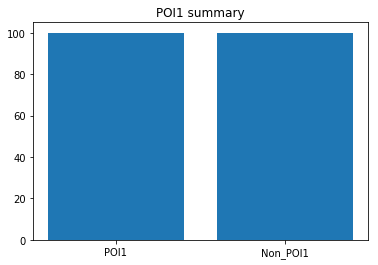

In [35]:
#顯示 train_Y_res 中 POI 的數量 
POI_num1 = [len(train_Y_res[train_Y_res==True]),len(train_Y_res[train_Y_res==False])]
print(f'The POI are {POI_num1[0]} , The Non-POI are {POI_num1[1]}')
plt.title('POI1 summary')
plt.bar(['POI1', 'Non_POI1'],POI_num1)

### 開始訓練模型及驗證模型績效

In [36]:
#建立梯度提升機
GBclf = GradientBoostingClassifier()

#特徵選擇
GBclf.fit(train_data_res, train_Y_res)
feats = pd.Series(data=GBclf.feature_importances_, index=train_data_res.columns)
feats = feats.sort_values(ascending=False)
feats

director_fees                0.591239
total_asset                  0.158761
restricted_stock_deferred    0.020000
total_communication          0.000000
from_poi_to_this_person      0.000000
bonus                        0.000000
deferral_payments            0.000000
deferred_income              0.000000
exercised_stock_options      0.000000
expenses                     0.000000
from_messages                0.000000
long_term_incentive          0.000000
from_this_person_to_poi      0.000000
other                        0.000000
restricted_stock             0.000000
salary                       0.000000
shared_receipt_with_poi      0.000000
to_messages                  0.000000
total_payments               0.000000
total_stock_value            0.000000
name                         0.000000
dtype: float64

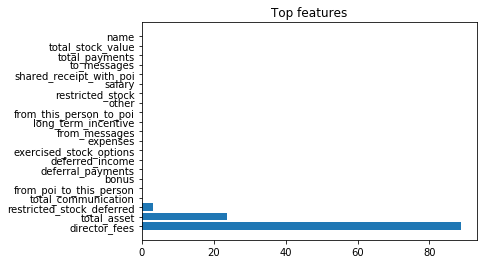

In [37]:
plt.title('Top features')
plt.barh(feats.index,feats*150)
plt.show()
#director_fees = 董事費
#total_asset = 總薪資及獎金 + 總股票價值

In [38]:
vaidScore=[]#交叉驗證
accScore=[]#分類準確率分數是指所有分類正確的百分比
recallScore=[]#召回率:所有準確的項目有多少被檢索出來
F1Score=[]#f1-score
randomState=4

for i in range(1,(len(train_data_res.columns)+1)//2):
    topfeatures = list(feats[:i].index)
    x_train, x_test, y_train, y_test = train_test_split(train_data_res[topfeatures],train_Y_res,
                                                    test_size=0.25, random_state=randomState)  
    GBclf.fit(x_train, y_train)
    y_pred = GBclf.predict(x_test)

    accScore.append(GBclf.score(x_test,y_test))
    vaidScore.append(cross_val_score(GBclf, x_train, y_train, cv=7).mean())
    recallScore.append(metrics.recall_score(y_true=y_test,y_pred=y_pred))
    F1Score.append(metrics.f1_score(y_true=y_test,y_pred=y_pred))

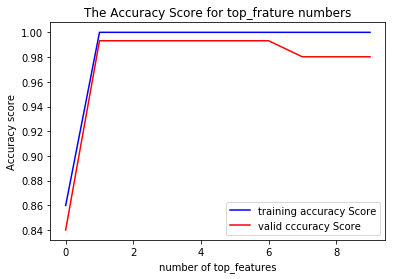

In [39]:
plt.plot(range(len(train_data_res.columns)//2),accScore,color='blue',label='training accuracy Score')
plt.plot(range(len(train_data_res.columns)//2),vaidScore,color='red',label='valid cccuracy Score')

plt.legend(loc='lower right')
plt.title('The Accuracy Score for top_frature numbers')
plt.xlabel('number of top_features')
plt.ylabel('Accuracy score')
plt.show()

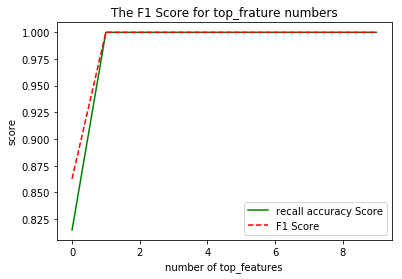

In [40]:
plt.plot(range(len(train_data_res.columns)//2),recallScore,color='green',label='recall accuracy Score')
plt.plot(range(len(train_data_res.columns)//2),F1Score,linestyle='--',color='red',label='F1 Score')
plt.legend(loc='lower right')
plt.title('The F1 Score for top_frature numbers')
plt.xlabel('number of top_features')
plt.ylabel('score')
plt.show()

### 經梯度提升樹的特徵選擇，前三項特徵已經呈現很明顯的重要性，但保險起見保留一點其他特徵的影響，故選用前五項特徵值來訓練模型。原本的訓練資料集有 21 個欄位，最後降維剩用五個特徵值來建立分類模型即可。 

In [41]:
#分割訓練資料集及驗證資料集
topfeatures = list(feats[:5].index)

x_train, x_test, y_train, y_test = train_test_split(train_data_res[topfeatures],train_Y_res,
                                                    test_size=0.25, random_state=randomState)

In [42]:
#使用前五大特徵值來畫模型的學習曲線
cv=7

train_sizes,train_scores,test_scores=learning_curve(estimator=GBclf,X=x_train,y=y_train,
                                                    train_sizes=np.linspace(0.1,1.0,10),
                                                     cv=cv,n_jobs=-1)
train_mean=np.mean(train_scores,axis=1)
train_std=np.std(train_scores,axis=1)
test_mean=np.mean(test_scores,axis=1)
test_std=np.std(test_scores,axis=1)

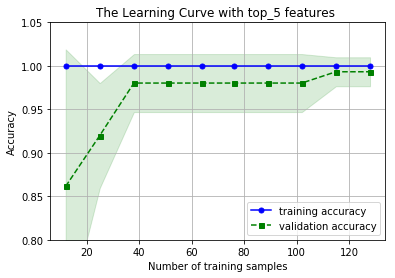

In [51]:
plt.plot(train_sizes,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean+train_std,train_mean-train_std,alpha=0.15,color='blue')

plt.plot(train_sizes,test_mean,color='green',linestyle='--',marker='s',markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean+test_std,test_mean-test_std,alpha=0.15,color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8,1.05])
plt.title('The Learning Curve with top_5 features ')
plt.show()

### 訓練資料集的數量能達到120 筆以上的話，驗證準確度會更接近訓練準確度 

In [52]:
print(f'The size of training data : {len(x_train)}')

The size of training data : 150


### 訓練集的資料150，已達 120 以上，應該可以訓練出高準確度的模型

In [53]:
#先交叉驗證一下模型分數
print(f'Gradient Boosting Clf Score : {cross_val_score(GBclf, x_train, y_train, cv=cv).mean()}')

Gradient Boosting Clf Score : 0.9931972789115646


In [54]:
#開始訓練模型及驗證模型能力
GBclf.fit(x_train, y_train)
y_pred = GBclf.predict(x_test)

print(f'Acc score : {GBclf.score(x_test,y_test)} \n')
print(metrics.classification_report(y_test, y_pred))

Acc score : 1.0 

             precision    recall  f1-score   support

      False       1.00      1.00      1.00        23
       True       1.00      1.00      1.00        27

avg / total       1.00      1.00      1.00        50



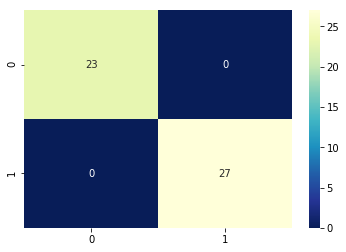

In [55]:
#使用混淆矩陣驗證分類的正確率
confmat = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(confmat, cmap='YlGnBu_r', annot=True, fmt='d');

### 用預設參數來建立的模型，各項評估指標已呈現極高的辨識率。可見前五項特徵值應是足夠。

In [56]:
#設定要訓練的超參數組合
n_estimators = [50 ,100, 150, 200, 250, 500]
max_depth = [1,3, 5, 7, 9, 11]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

#建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = GridSearchCV(GBclf, param_grid, scoring='accuracy', n_jobs=-1,cv=cv,iid =True)

# 開始搜尋最佳參數
grid_result = grid_search.fit(x_train, y_train)
print(f'Best Accuracy: {grid_result.best_score_} using {grid_result.best_params_}')

Best Accuracy: 0.9933333333333333 using {'max_depth': 1, 'n_estimators': 150}


In [57]:
# 使用最佳參數重新建立模型
clf_bestparam = GradientBoostingClassifier(max_depth = grid_result.best_params_['max_depth'],
                                           n_estimators = grid_result.best_params_['n_estimators'],\
                                           random_state = randomState)

In [58]:
#使用前五大特徵值來畫clf_bestparam模型的學習曲線
train_sizes,train_scores,test_scores=learning_curve(estimator=clf_bestparam,X=x_train,
                                                     y=y_train,train_sizes=np.linspace(0.1,1.0,10),
                                                     cv=cv,n_jobs=-1)
train_mean=np.mean(train_scores,axis=1)
train_std=np.std(train_scores,axis=1)

test_mean=np.mean(test_scores,axis=1)
test_std=np.std(test_scores,axis=1)

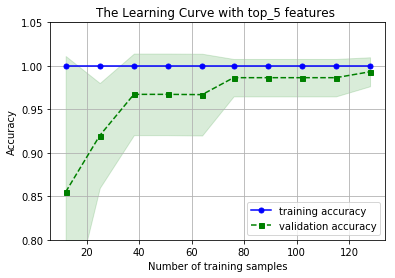

In [59]:
plt.plot(train_sizes,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean+train_std,train_mean-train_std,alpha=0.15,color='blue')

plt.plot(train_sizes,test_mean,color='green',linestyle='--',marker='s',markersize=5,
         label='validation accuracy')
plt.fill_between(train_sizes,test_mean+test_std,test_mean-test_std,alpha=0.15,color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8,1.05])
plt.title('The Learning Curve with top_5 features ')
plt.show()

In [60]:
# 訓練clf_bestparam模型
clf_bestparam.fit(x_train, y_train)

# 預測測試集
y_pred = clf_bestparam.predict(x_test)

print(f'Acuuracy of Best Param: {clf_bestparam.score(x_test,y_test)} \n')
print(metrics.classification_report(y_test, y_pred))

Acuuracy of Best Param: 1.0 

             precision    recall  f1-score   support

      False       1.00      1.00      1.00        23
       True       1.00      1.00      1.00        27

avg / total       1.00      1.00      1.00        50



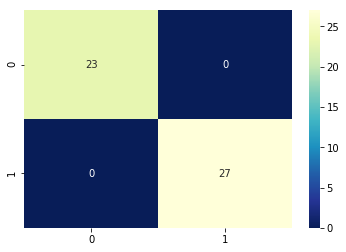

In [61]:
#使用混淆矩陣驗證分類的正確率
confmat = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(confmat, cmap='YlGnBu_r', annot=True, fmt='d')

### 經網格搜尋最佳的超參數之後，經過調整後的模型，辨識率也是極接近100%

### 將測試資料集套入訓練好的模型進行最終預測

In [62]:
#使用測試資料集套入模型進行最後預測
df1 = pd.read_csv('test_features.csv')
df1 = df1.drop(['email_address','loan_advances'],axis=1)

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 19 columns):
name                         33 non-null object
bonus                        21 non-null float64
deferral_payments            11 non-null float64
deferred_income              15 non-null float64
director_fees                4 non-null float64
exercised_stock_options      21 non-null float64
expenses                     22 non-null float64
from_messages                21 non-null float64
from_poi_to_this_person      21 non-null float64
from_this_person_to_poi      21 non-null float64
long_term_incentive          17 non-null float64
other                        24 non-null float64
restricted_stock             28 non-null float64
restricted_stock_deferred    8 non-null float64
salary                       22 non-null float64
shared_receipt_with_poi      21 non-null float64
to_messages                  21 non-null float64
total_payments               29 non-null float64
total_stock_value 

In [63]:
#針對各欄位的遺失值做資料清理及特徵工程
df_test = DataClean(df1)
df_test = Feature_eng(df_test)

In [64]:
df_test[topfeatures]

,director_fees,total_asset,restricted_stock_deferred,total_communication,from_poi_to_this_person
0,38346.0,6612335.0,7576788.0,336.0,228.0
1,98784.0,2921644.0,1787380.0,155.0,140.0
2,137864.0,6679747.0,315068.0,53.0,32.0
3,1398517.0,8362240.0,307301.0,675.0,66.0
4,0.0,4370821.0,140264.0,70.0,58.0
5,0.0,2522892.0,82782.0,41.0,40.0
6,0.0,31874715.0,32460.0,248.0,242.0
7,98784.0,1594677.0,32460.0,0.0,0.0
8,0.0,1956748.0,0.0,199.0,188.0
9,0.0,4616366.0,140264.0,0.0,0.0


In [65]:
#最後將測試資料集套入模型預測
y_pred = clf_bestparam.predict_proba(df_test[topfeatures]) 
POI_P = pd.DataFrame(y_pred)

In [66]:
#輸出測試資料集的預測結果
submit = pd.DataFrame(df1['name'],columns=['name'])
submit['poi'] = POI_P[0]
print(submit)

                    name       poi
0       BELDEN TIMOTHY N  0.001506
1     BOWEN JR RAYMOND M  0.001506
2         HANNON KEVIN P  0.001506
3       DELAINEY DAVID W  0.001506
4       CAUSEY RICHARD A  0.995005
5       HICKERSON GARY J  0.995005
6         FREVERT MARK A  0.995005
7            CHAN RONNIE  0.003855
8   DONAHUE JR JEFFREY M  0.998476
9      REYNOLDS LAWRENCE  0.996281
10      HORTON STANLEY C  0.998476
11         LEWIS RICHARD  0.999201
12    SHERRICK JEFFREY B  0.998476
13        MEYER JEROME J  0.006627
14   DERRICK JR. JAMES V  0.995005
15              PIRO JIM  0.999406
16   DETMERING TIMOTHY J  0.996281
17     KISHKILL JOSEPH G  0.998867
18        BAY FRANKLIN R  0.998048
19        PRENTICE JAMES  0.999406
20                 TOTAL  0.002024
21        FALLON JAMES B  0.998476
22            METTS MARK  0.999201
23         WODRASKA JOHN  0.998867
24   MORDAUNT KRISTINA M  0.999406
25      CARTER REBECCA C  0.995005
26      BHATNAGAR SANJAY  0.002024
27      WALTERS GARE

In [75]:
#輸出預測的嫌疑人數量及名單
POI_num =len(submit[submit['poi'] < 0.1]['name'])
print(f'{len(df1)} 筆的資料中有 {POI_num} 個詐欺嫌疑人!')
print(f'{POI_num} 個嫌疑人的姓名是 :\n')      
print(submit[submit['poi'] < 0.1]['name'])

33 筆的資料中有 8 個詐欺嫌疑人!
8 個嫌疑人的姓名是 :

0       BELDEN TIMOTHY N
1     BOWEN JR RAYMOND M
2         HANNON KEVIN P
3       DELAINEY DAVID W
7            CHAN RONNIE
13        MEYER JEROME J
20                 TOTAL
26      BHATNAGAR SANJAY
Name: name, dtype: object


In [76]:
#將嫌疑人預測結果輸出成 csv 檔案
submit.to_csv('Enron Fraund predict.csv',index = False)